<a href="https://colab.research.google.com/github/zhouchun0105/Fake-News-Detection-Project-BA865/blob/main/BA865_Fake_News_Classification_Project_SETUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
# Importing all necessary libraries and imports

# Basics
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# sklearn
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# NLTK 
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Setup and Data Cleaning

In [ ]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")

In [ ]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [ ]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [ ]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [ ]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data_all = pd.concat(frames)
news_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real/fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [ ]:
#Removing links and the headline from the date column
news_data_all = news_data_all[news_data_all.date.str.contains('Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec')]

In [ ]:
news_data_all['date'] = pd.to_datetime(news_data_all['date'])

In [ ]:
news_data_all.head()

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [ ]:
news_data_all.describe()

,title,text,subject,date,real/fake
count,44888,44888,44888,44888,44888
unique,38723,38640,8,1010,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20 00:00:00,0
freq,14,627,11272,197,23471
first,NaN,NaN,NaN,2015-03-31 00:00:00,NaN
last,NaN,NaN,NaN,2018-02-19 00:00:00,NaN


In [ ]:
# one-hot encoding for subject column
# news_data = pd.get_dummies(news_data_all, columns=["subject"])
news_data = news_data_all

In [ ]:
# dropping subject column as subjects across fake and real news articles are unbalanced
news_data = news_data.drop('subject', axis=1)

In [ ]:
# title and text can be two seperate variables
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      44888 non-null  object        
 1   text       44888 non-null  object        
 2   date       44888 non-null  datetime64[ns]
 3   real/fake  44888 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.7+ MB


# Text Processing

In [ ]:
import re
import string

In [ ]:
# merging the title and news text
news_data['content'] = news_data['title']+' '+news_data['text']
news_dataset = news_data.drop(['title', 'text'], axis=1)

News-Punctuation Cleaning

In [ ]:
#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    


In [ ]:
clean_news['content'] = clean_news['content'].apply(lambda x:review_cleaning(x))
clean_news.head()

,date,real/fake,content
0,2017-12-31,1,as us budget fight looms republicans flip thei...
1,2017-12-29,1,us military to accept transgender recruits on ...
2,2017-12-31,1,senior us republican senator let mr mueller do...
3,2017-12-30,1,fbi russia probe helped by australian diplomat...
4,2017-12-29,1,trump wants postal service to charge much more...


News-Stop words

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# removing english stopwords to save space and processing time
stop = stopwords.words('english')
clean_news['content'] = clean_news['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,date,real/fake,content
0,2017-12-31,1,us budget fight looms republicans flip fiscal ...
1,2017-12-29,1,us military accept transgender recruits monday...
2,2017-12-31,1,senior us republican senator let mr mueller jo...
3,2017-12-30,1,fbi russia probe helped australian diplomat ti...
4,2017-12-29,1,trump wants postal service charge much amazon ...


In [ ]:
clean_news['real/fake'] = clean_news['real/fake'].astype(int)

In [ ]:
clean_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       44888 non-null  datetime64[ns]
 1   real/fake  44888 non-null  int64         
 2   content    44888 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.4+ MB


# EDA

(-0.5, 1299.5, 949.5, -0.5)

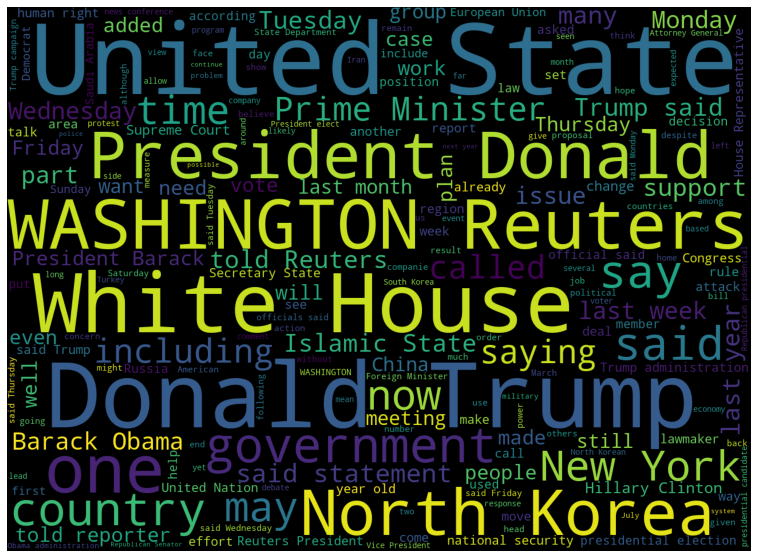

In [ ]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

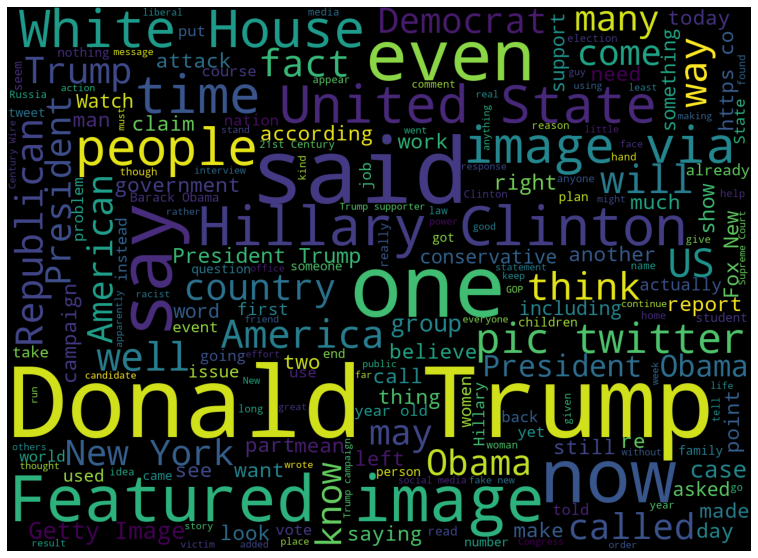

In [ ]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_fake['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# subsetting the cleaned, preprocessed news data for real and fake
top_words_real = clean_news[clean_news['real/fake'] == 1]
top_words_fake = clean_news[clean_news['real/fake'] == 0]

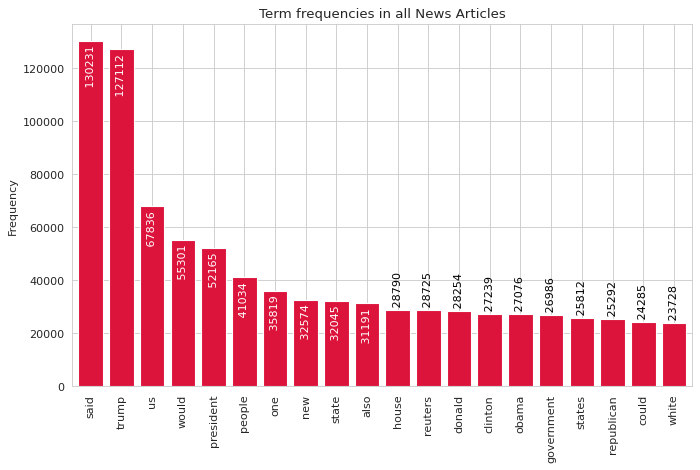

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(clean_news['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in ALL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
#plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

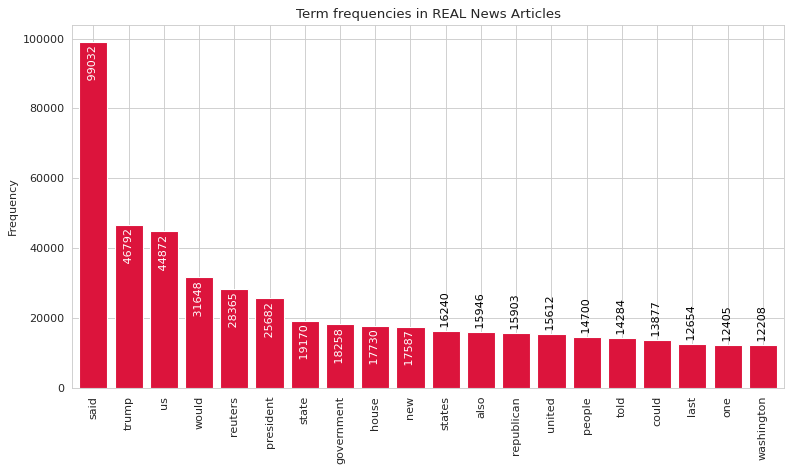

In [ ]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_real['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in REAL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

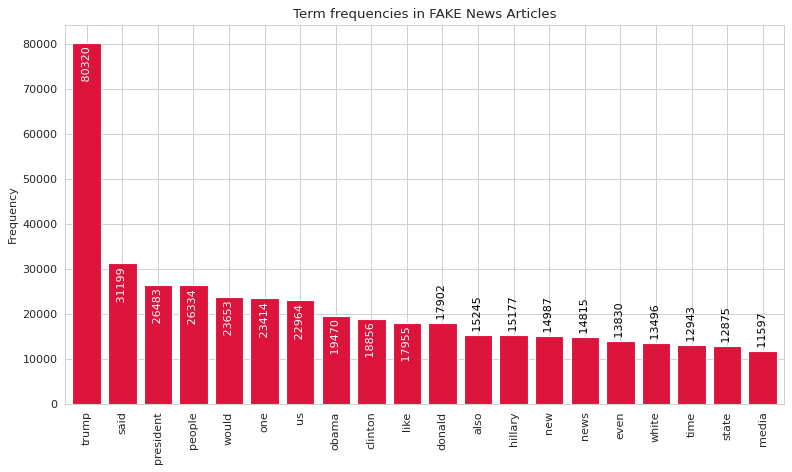

In [ ]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_fake['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in FAKE News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

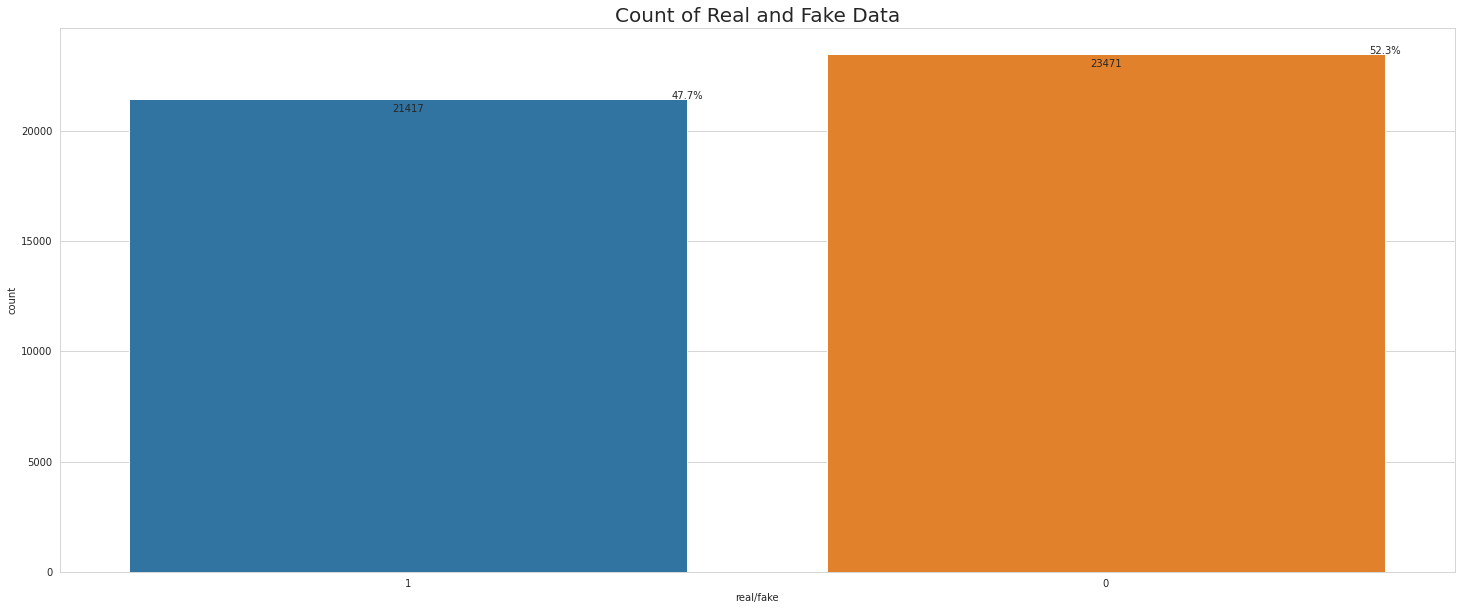

In [ ]:
total = float(len(news_data))

sns.set_style('whitegrid')
plt.figure(figsize= (25,10))
fig = sns.countplot(x='real/fake', data= news_data)
plt.title('Count of Real and Fake Data', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')

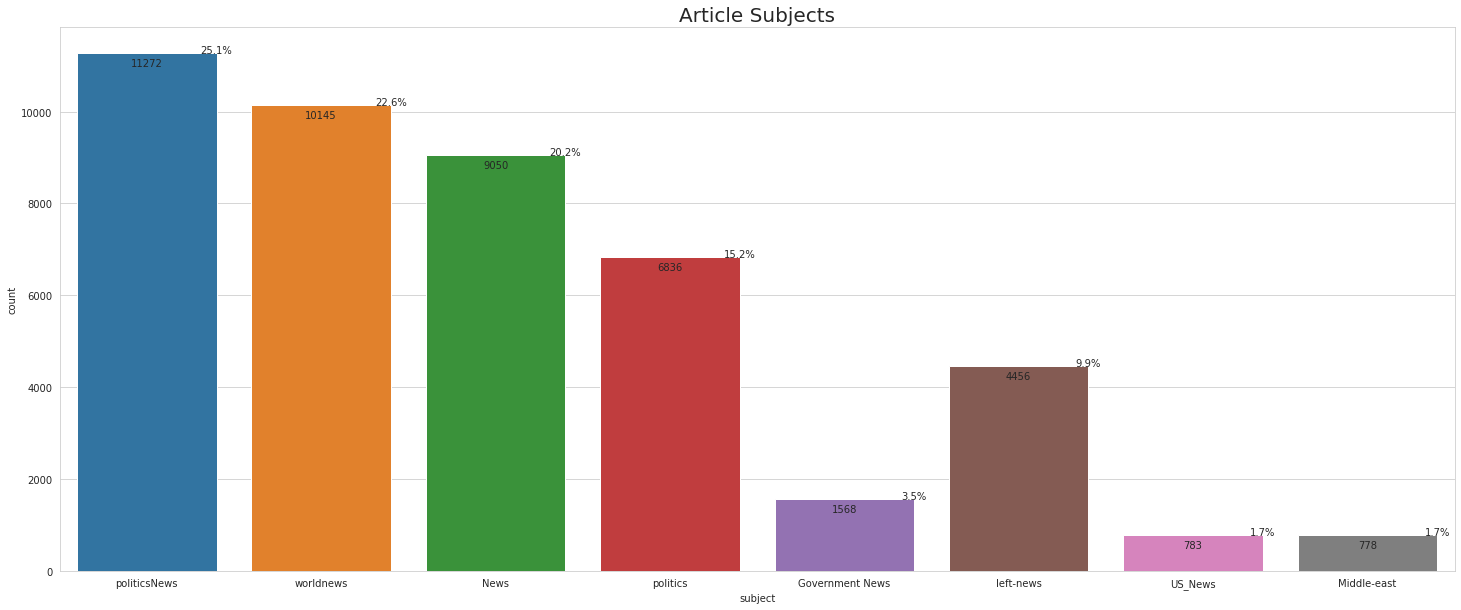

In [ ]:
#order=['unknown','Activated','Pending Activation','Inactivated','Non Standard MyChart Status','Patient Declined','Activation Code Generated, but Disabled']
total = float(len(news_data))


plt.figure(figsize= (25,10))
fig = sns.countplot(x='subject', data= news_data_all)
plt.title('Article Subjects', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')


In [ ]:
count = news_data_all.groupby(['subject','real/fake']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()
count

,subject,real/fake,count
0,politicsNews,1,11272
1,worldnews,1,10145
2,News,0,9050
3,politics,0,6836
4,left-news,0,4456
5,Government News,0,1568
6,US_News,0,783
7,Middle-east,0,778


In [ ]:
df_fakenews_true.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,politicsNews,11272
1,worldnews,10145


In [ ]:
df_fakenews_fake.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,News,9050
1,politics,6841
2,left-news,4459
3,Government News,1570
4,US_News,783
5,Middle-east,778


Time Serires Real/Fake News

# Import libraries

In [ ]:
# Importing all necessary libraries and imports

# Basics
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# sklearn
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# NLTK 
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Setup and Data Cleaning

In [ ]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")

In [ ]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [ ]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [ ]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [ ]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [ ]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data_all = pd.concat(frames)
news_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real/fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [ ]:
#Removing links and the headline from the date column
news_data_all = news_data_all[news_data_all.date.str.contains('Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec')]

In [ ]:
news_data_all['date'] = pd.to_datetime(news_data_all['date'])

In [ ]:
news_data_all.head()

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [ ]:
news_data_all.describe()

,title,text,subject,date,real/fake
count,44888,44888,44888,44888,44888
unique,38723,38640,8,1010,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20 00:00:00,0
freq,14,627,11272,197,23471
first,NaN,NaN,NaN,2015-03-31 00:00:00,NaN
last,NaN,NaN,NaN,2018-02-19 00:00:00,NaN


In [ ]:
# one-hot encoding for subject column
# news_data = pd.get_dummies(news_data_all, columns=["subject"])
news_data = news_data_all

In [ ]:
# dropping subject column as subjects across fake and real news articles are unbalanced
news_data = news_data.drop('subject', axis=1)

In [ ]:
# title and text can be two seperate variables
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      44888 non-null  object        
 1   text       44888 non-null  object        
 2   date       44888 non-null  datetime64[ns]
 3   real/fake  44888 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.7+ MB


# Text Processing

In [ ]:
import re
import string

In [ ]:
# merging the title and news text
news_data['content'] = news_data['title']+' '+news_data['text']
news_dataset = news_data.drop(['title', 'text'], axis=1)

News-Punctuation Cleaning

In [ ]:
#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    


In [ ]:
clean_news['content'] = clean_news['content'].apply(lambda x:review_cleaning(x))
clean_news.head()

,date,real/fake,content
0,2017-12-31,1,as us budget fight looms republicans flip thei...
1,2017-12-29,1,us military to accept transgender recruits on ...
2,2017-12-31,1,senior us republican senator let mr mueller do...
3,2017-12-30,1,fbi russia probe helped by australian diplomat...
4,2017-12-29,1,trump wants postal service to charge much more...


News-Stop words

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# removing english stopwords to save space and processing time
stop = stopwords.words('english')
clean_news['content'] = clean_news['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,date,real/fake,content
0,2017-12-31,1,us budget fight looms republicans flip fiscal ...
1,2017-12-29,1,us military accept transgender recruits monday...
2,2017-12-31,1,senior us republican senator let mr mueller jo...
3,2017-12-30,1,fbi russia probe helped australian diplomat ti...
4,2017-12-29,1,trump wants postal service charge much amazon ...


In [ ]:
clean_news['real/fake'] = clean_news['real/fake'].astype(int)

In [ ]:
clean_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       44888 non-null  datetime64[ns]
 1   real/fake  44888 non-null  int64         
 2   content    44888 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.4+ MB


# EDA

(-0.5, 1299.5, 949.5, -0.5)

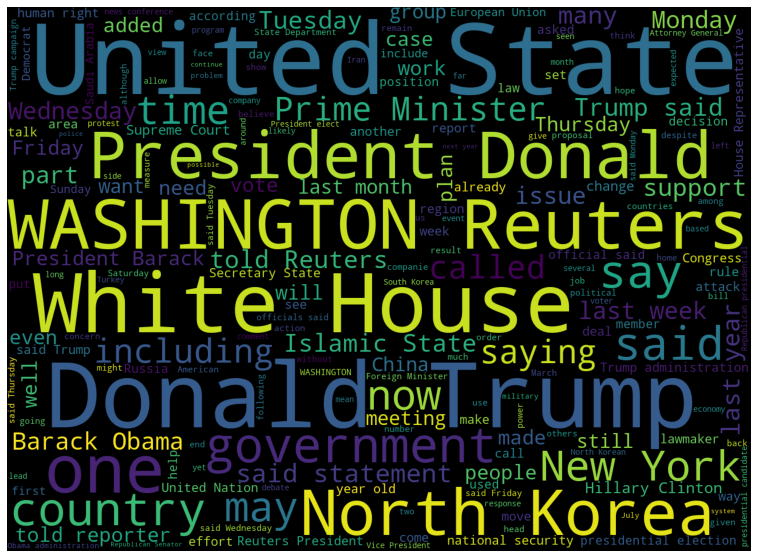

In [ ]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

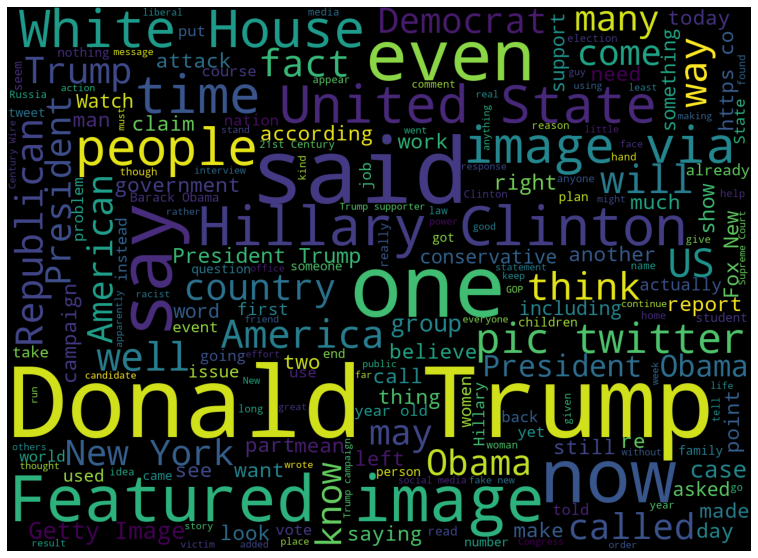

In [ ]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_fake['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# subsetting the cleaned, preprocessed news data for real and fake
top_words_real = clean_news[clean_news['real/fake'] == 1]
top_words_fake = clean_news[clean_news['real/fake'] == 0]

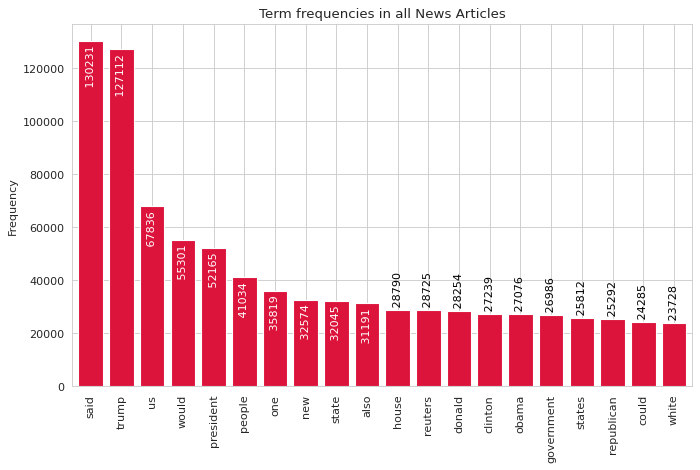

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(clean_news['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in ALL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
#plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

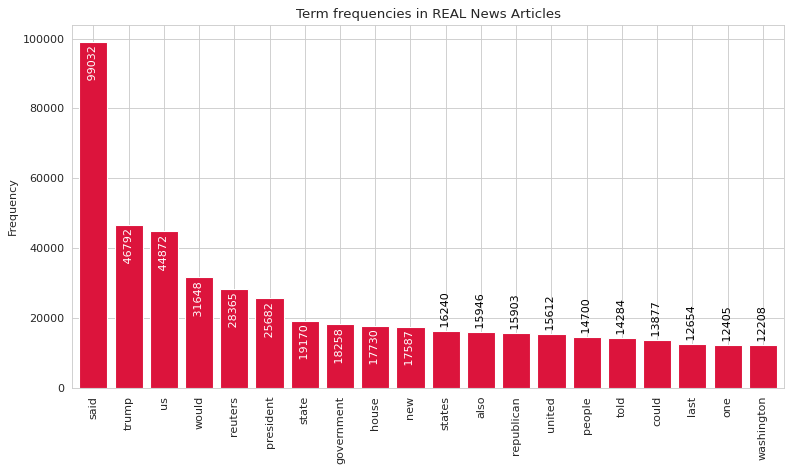

In [ ]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_real['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in REAL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

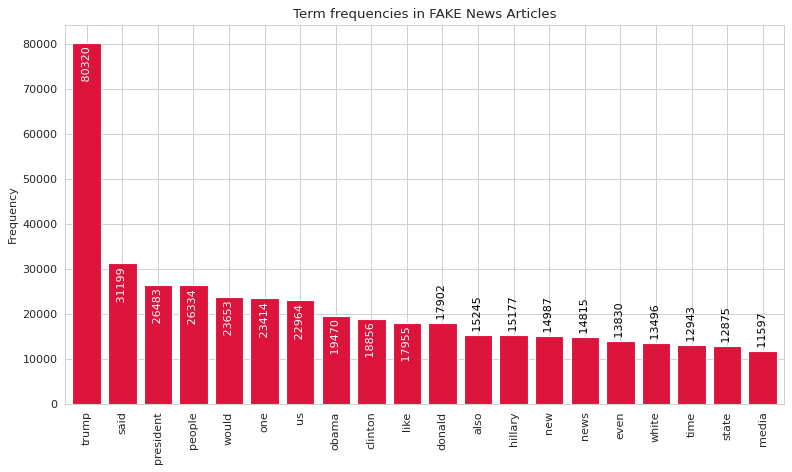

In [ ]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_fake['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in FAKE News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

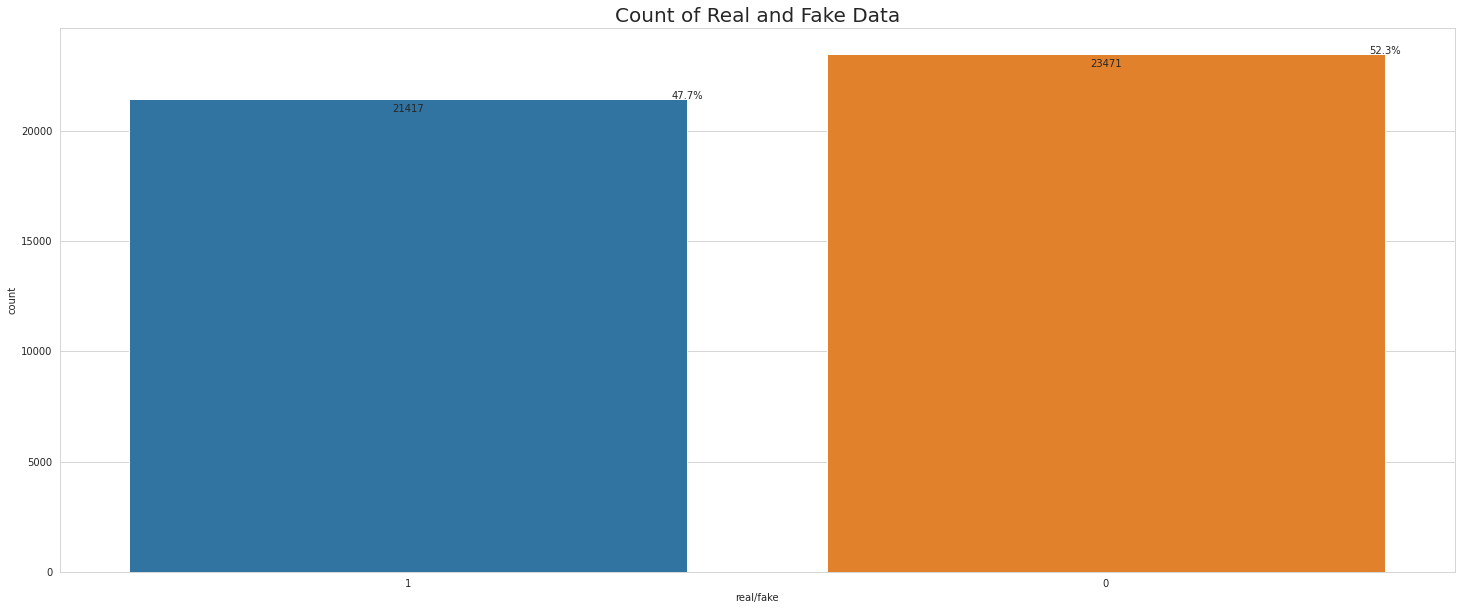

In [ ]:
total = float(len(news_data))

sns.set_style('whitegrid')
plt.figure(figsize= (25,10))
fig = sns.countplot(x='real/fake', data= news_data)
plt.title('Count of Real and Fake Data', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')

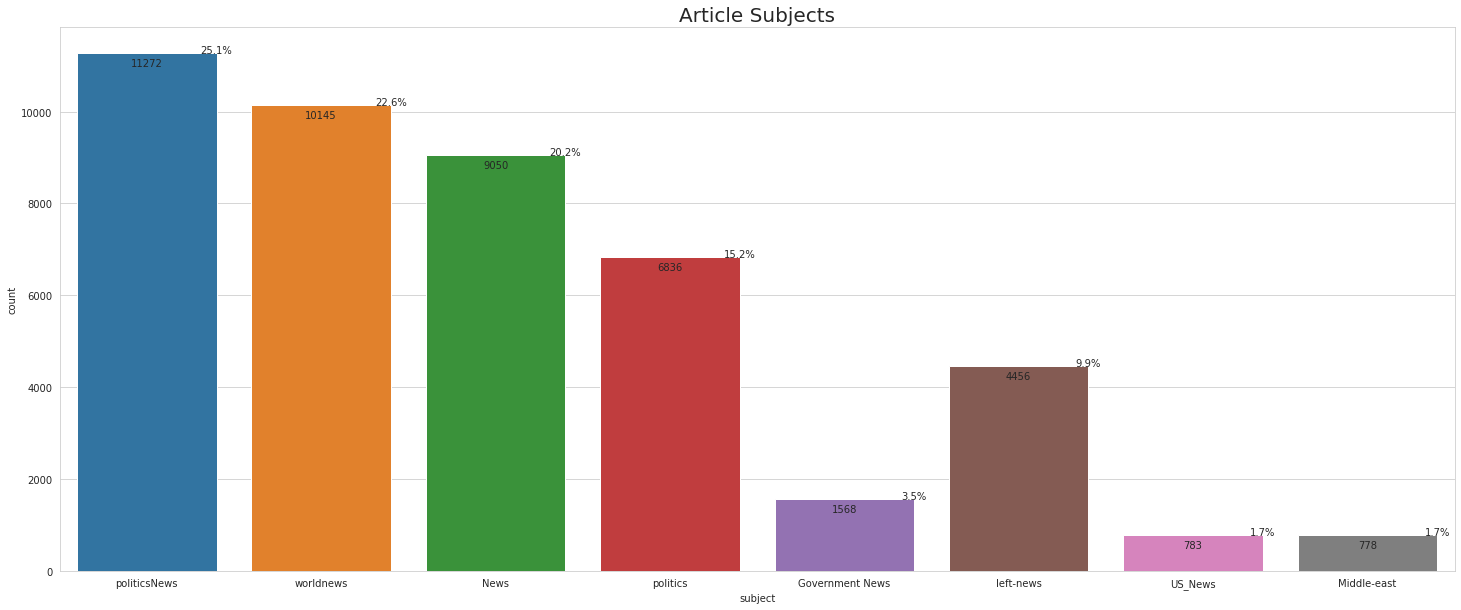

In [ ]:
#order=['unknown','Activated','Pending Activation','Inactivated','Non Standard MyChart Status','Patient Declined','Activation Code Generated, but Disabled']
total = float(len(news_data))


plt.figure(figsize= (25,10))
fig = sns.countplot(x='subject', data= news_data_all)
plt.title('Article Subjects', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')


In [ ]:
count = news_data_all.groupby(['subject','real/fake']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()
count

,subject,real/fake,count
0,politicsNews,1,11272
1,worldnews,1,10145
2,News,0,9050
3,politics,0,6836
4,left-news,0,4456
5,Government News,0,1568
6,US_News,0,783
7,Middle-east,0,778


In [ ]:
df_fakenews_true.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,politicsNews,11272
1,worldnews,10145


In [ ]:
df_fakenews_fake.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,News,9050
1,politics,6841
2,left-news,4459
3,Government News,1570
4,US_News,783
5,Middle-east,778


Time Serires Real/Fake News

# Deep Learning Models



*   LSTM
*   Bi directional LSTM
*   GloVe

